# 📊 Validating sentence_transformers using ČTK data
Shared notebook version 1.0

## 📑 Import Clauses

In [32]:
import gc
import json
import logging
import os
from collections import OrderedDict
from os.path import join as pjoin

import matplotlib.pyplot as plt
import numpy as np
import torch
from sentence_transformers.cross_encoder import CrossEncoder
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
)

import datautils
from datautils import LABEL_NUM, LABEL_STR

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ⚓ Load a model (see [Training NB](training.ipynb))

In [3]:
model_dir = "../models/deepset/xlm-roberta-large-squad2_bs8"
trn_examples, val_examples, tst_examples = datautils.load_examples_from_pickle(model_dir)

## 📈 Evaluation


In [39]:
mem = {}

def evaluate_examples(model, examples):
    Tcls = np.array([e.label for e in examples], dtype=np.float32)
    Y = model.predict([e.texts for e in examples], apply_softmax=True)
    Ycls = np.argmax(Y, axis=1)
    return Y, Ycls, Tcls

def load_and_evaluate_rte_model(model_dir):
    global mem
    if model_dir in mem:
        return mem[model_dir]

    with open(pjoin(model_dir, "rteconfig.json"), "r") as cfgfile:
        cfg = json.load(cfgfile)
    model = CrossEncoder(model_dir, num_labels=3, max_length=cfg["max_length"])

    evals = {}
    for sset, examples in [
        ("TRN", trn_examples),
        ("TST", tst_examples),
        ("VAL", val_examples),
    ]:
        Y, Ycls, Tcls = evaluate_examples(model, examples)
        evals[sset] = {"Y": Y, "Ycls": Ycls, "Tcls": Tcls}
    mem[model_dir] = cfg, model, evals
    return cfg, model, evals

In [20]:
cfg, model, evals = load_and_evaluate_rte_model(model_dir)

/home/ullriher/nli/notebooks/models_clean/deepset/xlm-roberta-large-squad2_bs8ctkclean1


### 🧮 Confusion matrices

deepset/xlm-roberta-large-squad2_bs8


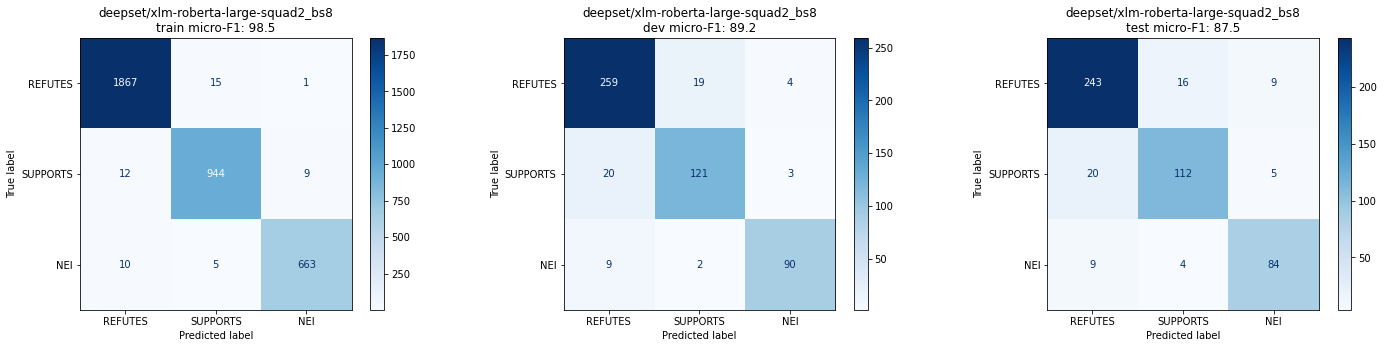

In [25]:
def evaluate_all(exp_dir):
    res = OrderedDict()
    for dirpath, dirnames, filenames in os.walk(exp_dir):
        try:
            if "rteconfig.json" not in filenames:
                continue
            print(dirpath)
            torch.cuda.empty_cache()
            gc.collect()
            cfg, model, e = load_and_evaluate_rte_model(dirpath)
            mres = OrderedDict()

            for sset in ["TRN", "TST", "VAL"]:
                acc = accuracy_score(e[sset]["Tcls"], e[sset]["Ycls"])
                f1 = f1_score(e[sset]["Tcls"], e[sset]["Ycls"], average="micro")
                f1_macro = f1_score(e[sset]["Tcls"], e[sset]["Ycls"], average="macro")
                cm = confusion_matrix(e[sset]["Tcls"], e[sset]["Ycls"])
                cm_true = confusion_matrix(
                    e[sset]["Tcls"], e[sset]["Ycls"], normalize="true"
                )
                cm_pred = confusion_matrix(
                    e[sset]["Tcls"], e[sset]["Ycls"], normalize="pred"
                )
                cm_all = confusion_matrix(
                    e[sset]["Tcls"], e[sset]["Ycls"], normalize="all"
                )

                mres[sset] = {
                    "acc": acc,
                    "cm": cm,
                    "f1": f1,
                    "f1_macro": f1_macro,
                    "cm_true": cm_true,
                    "cm_pred": cm_pred,
                    "cm_all": cm_all,
                    "e": e,
                }

            bert_name_short = cfg["bert_name_short"]
            batch_size = cfg["batch_size"]
            model_name = f"{bert_name_short}_bs{batch_size}"
            res[model_name] = mres
        except OSError:
            print("caught and skipped an oserror")
        except RuntimeError as e:
            print("caught and skipped a runtimeerror", e)
    return res


def display_results(res, substr="", cm_type="cm", splits=["TRN", "VAL", "TST"]):
    splitlabel = {"TRN": "train", "VAL": "dev", "TST": "test"}
    res = OrderedDict([(k, v) for k, v in res.items() if substr in k])
    res = OrderedDict(sorted(res.items(), key=lambda kv: -kv[1]["VAL"]["acc"]))

    nrows, ncols = len(res), len(list(res.values())[0])
    grid = plt.GridSpec(nrows, ncols, wspace=0.3, hspace=0.3)

    fig = plt.figure(figsize=(8 * ncols, 5 * nrows))
    fig.clf()
    i = 0
    for k, v in res.items():
        print(k)
        for sname in splits:
            sres = v[sname]
            acc, cm, f1, f1_macro = (
                sres["acc"],
                sres[cm_type],
                sres["f1"],
                sres["f1_macro"],
            )
            ax = fig.add_subplot(grid[i])
            ax.set_title(f"{k}\n{splitlabel[sname]} micro-F1: {100 * f1:.1f}")
            ConfusionMatrixDisplay(
                cm, display_labels=["REFUTES", "SUPPORTS", "NOT ENOUGH INFO"]
            ).plot(ax=ax, colorbar=True, cmap=plt.cm.Blues)
            i += 1
    plt.savefig("last_confmat.png", dpi=300)
    return fig


display_results(evaluate_all(model_dir));

In [27]:
Ytst, Ytst_cls, Ttst_cls = evaluate_examples(model, tst_examples)

In [40]:
def evaluate_claim(model, example, claim=None):
    context = example.texts[0]
    claim_ = example.texts[1] if claim is None else claim
    print(f"CONTEXT:\n{context}\n\nCLAIM:\n{claim_}\n")
    refutes, supports = model.predict([[context, claim_]], apply_softmax=True)[0]
    print(f"SUPPORTS: {100 * supports:0.2f}%, REFUTES: {100 * refutes:0.2f}%")
    if claim is None:
        print(f"TRUE LABEL: {'SUPPORTS' if example.label else 'REFUTES'}")

In [42]:
def print_predictions_json(target_class, pred_class, X, Y, Ycls, Tcls, dataset2):
    print(f"{target_class} (truth) -> {pred_class} (prediction)\n")
    ids = np.where(np.logical_and(Tcls == LABEL_NUM[target_class], Ycls == LABEL_NUM[pred_class]))[
        0
    ]
    for id_ in ids:
        txt, claim = X[id_]
        rec = [rec for rec in tst_examples if rec.texts[1] == claim][0]
        print(json.dumps({"claim":str(rec.guid),"trueLabel":LABEL_STR[rec.label], "prediction":{pred_class}, "certainty":float(f"{100 * Y[id_][LABEL_NUM[pred_class]]:0.2f}")},ensure_ascii=False)+",")

def print_predictions(target_class, pred_class, X, Y, Ycls, Tcls, dataset2):
    print(f"{target_class} (truth) -> {pred_class} (prediction)\n")
    ids = np.where(np.logical_and(Tcls == LABEL_NUM[target_class], Ycls == LABEL_NUM[pred_class]))[
        0
    ]
    for id_ in ids:
        txt, claim = X[id_]
        rec = [rec for rec in tst_examples if rec.texts[1] == claim][0]
        print(f"CLAIM ({LABEL_STR[rec.label]} id={rec.guid}, date=12.08.1994): {claim}")  # id={rec}
        print(f"prediction {pred_class}: {100 * Y[id_][LABEL_NUM[pred_class]]:0.2f}%\n")
        print(txt)
        print("--------------------------------------------------------------------\n")

for (a, b) in [("REFUTES", "NOT ENOUGH INFO"), ("REFUTES", "SUPPORTS"), ("SUPPORTS", "REFUTES"), ("SUPPORTS", "NOT ENOUGH INFO"),
               ("NOT ENOUGH INFO", "REFUTES"), ("NOT ENOUGH INFO", "SUPPORTS"), ]:
    print_predictions_json(
        a,
        b,
        [x.texts for x in tst_examples],
        evals["TST"]["Y"],
        evals["TST"]["Ycls"],
        evals["TST"]["Tcls"],
        tst_examples,
    )

['Moskva 17. října (ČTK) - Polsko uzavřelo s Ruskem na vládní úrovni novou dohodu o dodávkách zemního plynu, která bude vyhovovat požadavkům Evropské komise. Sdělili to dnes vyjednavači obou stran. Dohodu by v nejbližší době měly finalizovat plynárenské podniky obou zemí.', 'Rusko a Polsko se domluvily na dalším dodávání plynu.']
REFUTES (truth) -> SUPPORTS (prediction)

CLAIM (REFUTES id=1422, date=12.08.1994): U didaktického testu z matematiky loni u státní maturity uspělo 22,3 % studentů.
prediction SUPPORTS: 100.00%

Zvýšení počtu vyučovacích hodin matematiky a zachování možnosti volby dobrovolné obtížnější zkoušky z matematiky u státních maturit doporučil ministerstvu výbor Jednoty českých matematiků a fyziků (JČMF). Větší počet matematických hodin by podle něj přispěl k větší úspěšnosti u maturity z matematiky, která by se nejpozději od školního roku 2021/2022 měla stát povinnou na téměř všech maturitních oborech. Loni si matematiku vybralo 23,4 procenta maturantů a 22,3 procenta